# Initial Exploration and Cleansing of cycleJourneys

This is for the initial exploration of the cycleJourneys dataset, primarily focusing on data integrity, and the best approaches to data-cleaning. 

This notebook is experimental and exploratory in nature. _The implemented fixes_ are in `clean_combined_cycle_data.py`

In [7]:
import pandas as pd
import random
import networkx as nx
from matplotlib import pyplot as plt
import numpy as np
import seaborn as sns
from pathlib import Path
from os import getcwd, chdir

In [8]:
# work from the project root
if getcwd()[-9:] == 'notebooks':
    chdir("..")

In [10]:
journeys_path = Path('tfl_project/data/cycle_journeys/JourneysDataCombined.csv')
stations_path = Path('tfl_project/data/cycle_journeys/Station Lookup.csv')

---
# Dates and Durations

## Sample Journeys and Inspect

In [48]:
# We will sample just 5% of journeys, using skiprows
p = 0.01 
random.seed(16)

df_samp = pd.read_csv(
        journeys_path
        ,header=0
        ,sep=','
        ,skiprows=lambda i: i>0 and random.random() > p
        ,parse_dates=['Start Date', 'End Date']
        ,infer_datetime_format=True
        ,dayfirst=True
)

In [49]:
df_samp.head()

,Rental Id,Duration,Bike Id,End Date,EndStation Id,Start Date,StartStation Id
0,50754299.0,1320.0,3118.0,2016-01-10 00:50:00,686.0,2016-01-10 00:28:00,166.0
1,50754531.0,4860.0,11001.0,2016-01-10 02:56:00,481.0,2016-01-10 01:35:00,654.0
2,50754559.0,300.0,397.0,2016-01-10 01:45:00,192.0,2016-01-10 01:40:00,244.0
3,50754568.0,300.0,8480.0,2016-01-10 01:50:00,197.0,2016-01-10 01:45:00,230.0
4,50754625.0,840.0,863.0,2016-01-10 02:20:00,664.0,2016-01-10 02:06:00,738.0


In [50]:
df_samp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 824980 entries, 0 to 824979
Data columns (total 7 columns):
 #   Column           Non-Null Count   Dtype         
---  ------           --------------   -----         
 0   Rental Id        812558 non-null  float64       
 1   Duration         810882 non-null  float64       
 2   Bike Id          812555 non-null  float64       
 3   End Date         810882 non-null  datetime64[ns]
 4   EndStation Id    810710 non-null  float64       
 5   Start Date       812558 non-null  datetime64[ns]
 6   StartStation Id  812558 non-null  float64       
dtypes: datetime64[ns](2), float64(5)
memory usage: 44.1 MB


## Start Dates

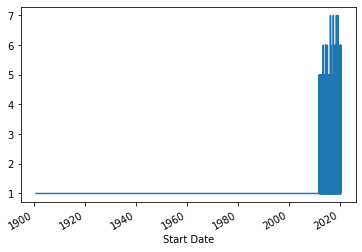

In [51]:
# Plot timeseries of journey volumes
df_samp.groupby('Start Date').count()['Rental Id'].plot()

**issue:** A handful of rows have 1900 start-dates, but such cases it appears End Date is valid, we can just reverse-engineer the Sart Date

In [52]:
def correct_start_date_errors(df):
    """ Void function: adds 'Start Date 2' column to the dataframe.
    Dataset contains start dates in 1900. In such cases, the complimenting end date column appears
    to be correct, as well as the duration. This function attempts to fix the implausible start dates. 
    """
    
    # Correct inplausible start dates 
    df['Start Date 2']= df['Start Date'].where(
        (df['Start Date'] >= '2012') | (df['End Date'] < '2012')  # If start date is after 2012 we can trust it. If end date is before 2012, the fix won't work
        ,df['End Date'] - pd.to_timedelta(df['Duration'], unit='s')  # else: correct start_date using end date
        ,axis=0
    )


In [53]:
correct_start_date_errors(df_samp)

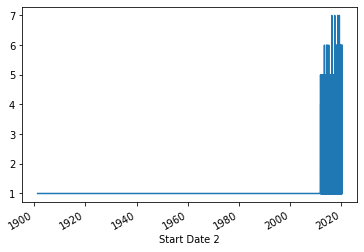

In [54]:
# Plot 'corrected' timeseries of journeys
df_samp.groupby('Start Date 2').count()['Rental Id'].plot()

In `Start Date 2` the error has been corrected

## End Date

### End Dates before 2012

In [55]:
df_samp[df_samp['End Date'] < '2012'].sample(10)

,Rental Id,Duration,Bike Id,End Date,EndStation Id,Start Date,StartStation Id,Start Date 2
43569,9680684.0,0.000000e+00,1784.0,1970-01-01,0.0,2012-01-23 13:09:00,141.0,2012-01-23 13:09:00
740005,22938465.0,-1.373218e+09,7996.0,1970-01-01,0.0,2013-07-07 17:20:00,410.0,2013-07-07 17:20:00
561230,20778296.0,-1.366216e+09,7199.0,1970-01-01,0.0,2013-04-17 16:31:00,457.0,2013-04-17 16:31:00
107213,15499056.0,-1.345792e+09,1516.0,1970-01-01,0.0,2012-08-24 07:06:00,126.0,2012-08-24 07:06:00
42693,9575259.0,0.000000e+00,576.0,1970-01-01,0.0,2012-01-17 16:14:00,281.0,2012-01-17 16:14:00
679652,22228635.0,-1.371155e+09,8968.0,1970-01-01,0.0,2013-06-13 20:25:00,251.0,2013-06-13 20:25:00
295305,17360559.0,-1.350928e+09,1742.0,1970-01-01,0.0,2012-10-22 17:50:00,506.0,2012-10-22 17:50:00
257851,15816099.0,-1.346663e+09,6750.0,1970-01-01,0.0,2012-09-03 09:04:00,405.0,2012-09-03 09:04:00
290340,16855466.0,-1.349369e+09,2491.0,1970-01-01,0.0,2012-10-04 16:46:00,471.0,2012-10-04 16:46:00
362581,18851696.0,-1.356874e+09,634.0,1970-01-01,0.0,2012-12-30 13:25:00,144.0,2012-12-30 13:25:00


In [56]:
df_samp[df_samp['End Date'] < '2012']['EndStation Id'].value_counts()

0.0    2521
Name: EndStation Id, dtype: int64

In [57]:
df_samp[df_samp['End Date'] < '2012']['Start Date 2'].dt.year.value_counts()

2013    1471
2012    1213
1901       1
Name: Start Date 2, dtype: int64

Some rows have an end date on the epoch. These all occur when the start date is in 2012-2013 and in every case the EndStation Id is '0' (NA)

I suspect that these are journeys without an EndStation (i.e. theft etc) and that the End Date was supposed to be 'NaT' but got replaced with zero, which was then interpreted as 1970-01-01

To test this, I will see if there are similar volumes of 'NaT' after 2013

In [58]:
# Volumes of NaT over years
df_samp[df_samp['End Date'].isna()]['Start Date 2'].dt.year.value_counts()

2016.0    1013
2017.0     663
Name: Start Date 2, dtype: int64

In [59]:
df_samp[df_samp['EndStation Id'].isna() | (df_samp['EndStation Id']==0)]['Start Date 2'].dt.year.value_counts()

2013.0    1474
2012.0    1247
2016.0    1016
2017.0     667
1901.0       1
2015.0       1
Name: Start Date 2, dtype: int64

For unknown reasons 'lost bike journeys' seem to be absent from the 2014/2015 datasets. 

But, the volumes of End Stations and End Dates == 0 in 2012-2013 are comparable to the volumes where they are NaN and NaT respectively in 2016/2017. 

So, the best action is to replace these cases with NaN/NaT. Also: correct duration

In [60]:
def correct_0_end_date_stations(df):
    """ Void function: adds 'End Date 2' and 'EndStation Id 2' and 'Duration 2' columns to the dataframe.
    In 2012/2013, missing end dates and missing end stations are encoded as 1970-01-01 and 0, respectively. 
    This function replaces those cases with NaT and NaN
    """
    
    # Replace 1970 End Dates with NaT 
    df['End Date 2']= df['End Date'].where(
        df['End Date'] >= '2012'
        ,pd.NaT
        ,axis=0
    )
    
    df['Duration 2']= df['Duration'].where(
        (df['End Date'] >= '2012') & (df['Duration'] >= 0)
        ,np.NaN
        ,axis=0
    )
    
    df['EndStation Id 2'] = df['EndStation Id'].where(
        df['EndStation Id'] != 0
        ,np.NaN
    )


In [61]:
correct_0_end_date_stations(df_samp)

In [62]:
df_samp[df_samp['End Date'] < '2012'].sample(5)

,Rental Id,Duration,Bike Id,End Date,EndStation Id,Start Date,StartStation Id,Start Date 2,End Date 2,Duration 2,EndStation Id 2
529321,20436859.0,-1.364463e+09,600.0,1970-01-01,0.0,2013-03-28 09:22:00,315.0,2013-03-28 09:22:00,NaT,NaN,NaN
488625,10335797.0,0.000000e+00,2833.0,1970-01-01,0.0,2012-03-02 12:01:00,213.0,2012-03-02 12:01:00,NaT,NaN,NaN
157632,15556338.0,-1.346001e+09,44.0,1970-01-01,0.0,2012-08-26 17:16:00,532.0,2012-08-26 17:16:00,NaT,NaN,NaN
265522,16598012.0,-1.348580e+09,8735.0,1970-01-01,0.0,2012-09-25 13:35:00,294.0,2012-09-25 13:35:00,NaT,NaN,NaN
681768,22038563.0,-1.370414e+09,130.0,1970-01-01,0.0,2013-06-05 06:35:00,46.0,2013-06-05 06:35:00,NaT,NaN,NaN


End Date / Negative Duration Issue corrected. 

## Duration

Explore whether there are any other issues with this field

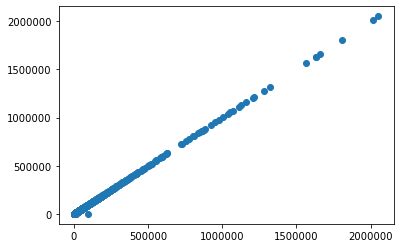

In [63]:
# Compare Duration 2 field with a manually-calculated duration field to validate
df_samp['duration_from_dates'] = (df_samp['End Date 2'] - df_samp['Start Date 2'])/np.timedelta64(1,'s')
plt.scatter(df_samp['Duration 2'].tolist(), df_samp['duration_from_dates'].tolist())

In [64]:
# sns.jointplot(
#     x="Duration 2"
#     , y="duration_from_dates"
#     , data=df_samp
#     , kind="hex")

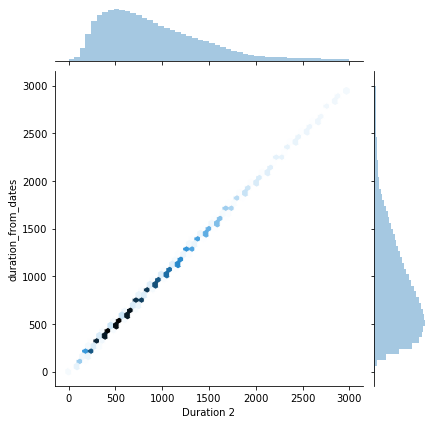

In [65]:
zoom = (df_samp['Duration 2'] < 3000) & (df_samp['duration_from_dates'] < 3000) & (df_samp['duration_from_dates'] >= 0)

sns.jointplot(
    x="Duration 2"
    , y="duration_from_dates"
    , data=df_samp[zoom]
    , kind="hex")

In [66]:
df_samp['End Date from Duration'] = df_samp['Start Date 2'] + pd.to_timedelta(df_samp['Duration 2'], unit='s')

In [67]:
# Inspect rows where diffirence is larger than 10%
df_samp[
    (df_samp['duration_from_dates'] - df_samp['Duration 2'])/df_samp['duration_from_dates'] > 0.1
].sample(10)

,Rental Id,Duration,Bike Id,End Date,EndStation Id,Start Date,StartStation Id,Start Date 2,End Date 2,Duration 2,EndStation Id 2,duration_from_dates,End Date from Duration
559487,20606808.0,436.0,8373.0,2013-04-08 17:54:08,63.0,2013-04-08 17:46:00,41.0,2013-04-08 17:46:00,2013-04-08 17:54:08,436.0,63.0,488.0,2013-04-08 17:53:16
783204,24008508.0,215.0,8102.0,2013-08-10 00:42:00,310.0,2013-08-10 00:38:00,74.0,2013-08-10 00:38:00,2013-08-10 00:42:00,215.0,310.0,240.0,2013-08-10 00:41:35
528749,20373501.0,160.0,2407.0,2013-03-25 07:40:00,254.0,2013-03-25 07:37:00,264.0,2013-03-25 07:37:00,2013-03-25 07:40:00,160.0,254.0,180.0,2013-03-25 07:39:40
40763,9380078.0,429.0,3983.0,2012-01-06 09:20:00,256.0,2012-01-06 09:12:00,68.0,2012-01-06 09:12:00,2012-01-06 09:20:00,429.0,256.0,480.0,2012-01-06 09:19:09
57239,15421794.0,323.0,6187.0,2012-08-22 07:54:00,56.0,2012-08-22 07:48:00,410.0,2012-08-22 07:48:00,2012-08-22 07:54:00,323.0,56.0,360.0,2012-08-22 07:53:23
260827,16112392.0,153.0,5734.0,2012-09-10 07:24:00,270.0,2012-09-10 07:21:00,100.0,2012-09-10 07:21:00,2012-09-10 07:24:00,153.0,270.0,180.0,2012-09-10 07:23:33
43623,9674686.0,160.0,2618.0,2012-01-23 17:44:00,268.0,2012-01-23 17:41:00,243.0,2012-01-23 17:41:00,2012-01-23 17:44:00,160.0,268.0,180.0,2012-01-23 17:43:40
416454,19374281.0,159.0,4663.0,2013-01-29 10:46:00,268.0,2013-01-29 10:43:00,243.0,2013-01-29 10:43:00,2013-01-29 10:46:00,159.0,268.0,180.0,2013-01-29 10:45:39
563959,21048362.0,512.0,2005.0,2013-04-27 12:16:30,73.0,2013-04-27 12:07:00,512.0,2013-04-27 12:07:00,2013-04-27 12:16:30,512.0,73.0,570.0,2013-04-27 12:15:32
103503,27784374.0,207.0,2292.0,2013-09-26 19:38:00,25.0,2013-09-26 19:34:00,214.0,2013-09-26 19:34:00,2013-09-26 19:38:00,207.0,25.0,240.0,2013-09-26 19:37:27


In [68]:
df_samp[df_samp['duration_from_dates'] < 0]

,Rental Id,Duration,Bike Id,End Date,EndStation Id,Start Date,StartStation Id,Start Date 2,End Date 2,Duration 2,EndStation Id 2,duration_from_dates,End Date from Duration
136880,49063702.0,-780.0,103.0,2015-10-25 01:35:00,194.0,2015-10-25 01:48:00,480.0,2015-10-25 01:48:00,2015-10-25 01:35:00,NaN,194.0,-780.0,NaT
141169,38748971.0,-3180.0,119.0,2014-10-26 01:03:00,10.0,2014-10-26 01:56:00,295.0,2014-10-26 01:56:00,2014-10-26 01:03:00,NaN,10.0,-3180.0,NaT
147974,38748937.0,-2940.0,688.0,2014-10-26 01:01:00,403.0,2014-10-26 01:50:00,337.0,2014-10-26 01:50:00,2014-10-26 01:01:00,NaN,403.0,-2940.0,NaT
468070,59897994.0,-2040.0,9245.0,2016-10-30 01:01:00,583.0,2016-10-30 01:35:00,693.0,2016-10-30 01:35:00,2016-10-30 01:01:00,NaN,583.0,-2040.0,NaT
469747,59898015.0,-2280.0,9662.0,2016-10-30 01:00:00,818.0,2016-10-30 01:38:00,509.0,2016-10-30 01:38:00,2016-10-30 01:00:00,NaN,818.0,-2280.0,NaT


It seems that in some cases, the End Date (or start date??) is wrong but the times are in fact correct. It seems that timings around midnight or the new year might be some cases. 

I think a possible approach might be to contrast Duration 2 and duration_from_dates and to pick the one that is more 'plausible' in each case. 

'plausible' might be measured by how many standard deviations is is away from the mean. Or perhaps, Duration 2 is always the best option

End Date is also broken!

## Prototyping my date correction Idea

//TODO: document this in markdown

In [69]:
df_s_clean = df_samp[~df_samp[['End Date 2', 'Duration 2', 'Start Date 2']].isnull().any(axis=1)]

In [70]:
df_s_clean[df_s_clean['Duration 2'] != df_s_clean['duration_from_dates']]

,Rental Id,Duration,Bike Id,End Date,EndStation Id,Start Date,StartStation Id,Start Date 2,End Date 2,Duration 2,EndStation Id 2,duration_from_dates,End Date from Duration
39568,18892018.0,466.0,7201.0,2013-01-02 18:12:00,64.0,2013-01-02 18:04:00,260.0,2013-01-02 18:04:00,2013-01-02 18:12:00,466.0,64.0,480.0,2013-01-02 18:11:46
39569,18950611.0,823.0,4575.0,2013-01-05 11:09:00,331.0,2013-01-05 10:55:00,314.0,2013-01-05 10:55:00,2013-01-05 11:09:00,823.0,331.0,840.0,2013-01-05 11:08:43
39570,18919030.0,578.0,3522.0,2013-01-03 08:50:00,233.0,2013-01-03 08:41:00,284.0,2013-01-03 08:41:00,2013-01-03 08:50:00,578.0,233.0,540.0,2013-01-03 08:50:38
39571,18928492.0,854.0,349.0,2013-01-04 08:23:00,190.0,2013-01-04 08:08:00,91.0,2013-01-04 08:08:00,2013-01-04 08:23:00,854.0,190.0,900.0,2013-01-04 08:22:14
39572,18928002.0,650.0,1784.0,2013-01-04 23:41:00,153.0,2013-01-04 23:30:00,255.0,2013-01-04 23:30:00,2013-01-04 23:41:00,650.0,153.0,660.0,2013-01-04 23:40:50
...,...,...,...,...,...,...,...,...,...,...,...,...,...
790342,23580005.0,1028.0,1884.0,2013-07-26 05:36:00,312.0,2013-07-26 05:18:00,49.0,2013-07-26 05:18:00,2013-07-26 05:36:00,1028.0,312.0,1080.0,2013-07-26 05:35:08
790343,23603517.0,798.0,3114.0,2013-07-27 14:34:00,200.0,2013-07-27 14:20:00,298.0,2013-07-27 14:20:00,2013-07-27 14:34:00,798.0,200.0,840.0,2013-07-27 14:33:18
790344,23602287.0,481.0,4602.0,2013-07-27 09:17:00,33.0,2013-07-27 09:09:00,132.0,2013-07-27 09:09:00,2013-07-27 09:17:00,481.0,33.0,480.0,2013-07-27 09:17:01
790345,23849321.0,5368.0,9084.0,2013-08-04 11:12:00,584.0,2013-08-04 09:42:00,584.0,2013-08-04 09:42:00,2013-08-04 11:12:00,5368.0,584.0,5400.0,2013-08-04 11:11:28


## Inspecting where the errors occur in time

In [71]:
df_samp['suspect_dates'] = abs((df_samp['Duration 2'] - df_samp['duration_from_dates'])/df_samp['Duration 2']) > 1

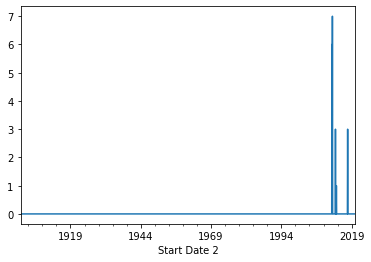

In [72]:
df_samp.set_index('Start Date 2')['suspect_dates'].resample('M').sum().plot()

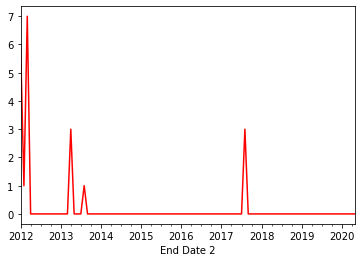

In [73]:
df_samp.set_index('End Date 2')['suspect_dates'].resample('M').sum().plot(color='r')

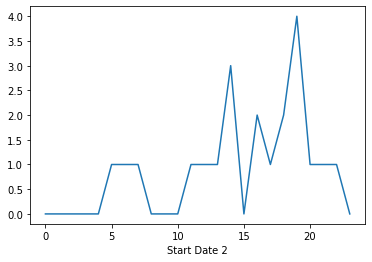

In [74]:
df_samp['suspect_dates'].groupby(df_samp['Start Date 2'].dt.hour).sum().plot()

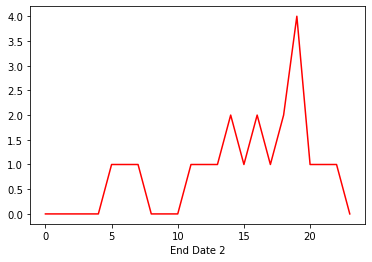

In [75]:
df_samp['suspect_dates'].groupby(df_samp['End Date 2'].dt.hour).sum().plot(color='r')

In [76]:
df_samp['suspect_dates'].groupby([df_samp['Start Date 2'].dt.hour, df_samp['Start Date 2'].dt.minute]).sum().plot()

TypeError: no numeric data to plot

In [77]:
df_samp['suspect_dates'].groupby([df_samp['End Date 2'].dt.hour, df_samp['End Date 2'].dt.minute]).sum().plot(color='r')

TypeError: no numeric data to plot

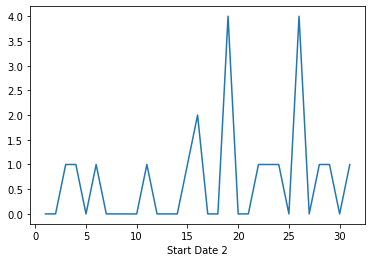

In [78]:
df_samp['suspect_dates'].groupby(df_samp['Start Date 2'].dt.day).sum().plot()

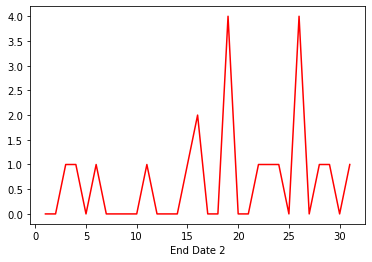

In [79]:
df_samp['suspect_dates'].groupby(df_samp['End Date 2'].dt.day).sum().plot(color='r')

This confirms my suspcions that this related to the end of the day and the cross-over to the next day.

It appears that start date is reliable and the issue is related to how end-date is calculated. I'm not sure how to reproduce it in all edge cases (e.g. last day of the month) but a typical non-edge-case is:

* start date is (Y, M, D) with a time close to the end of the day
* end date is expected to be (Y, M, D+1) with hours in the early morning
* Given end date is in-fact: (Y, D, M+1) with hours in the early morning

It seems that a good fix would be to _assume start date and duration are accurate_ and correct the end-date. 

In [80]:
def correct_suspect_enddates(df, tolerance=60):
    """ Void function: adds 'End Date 3' column to the dataframe. 
    
    There appears to be an issue where end-dates are inconsistent with duration, especially when a journey passes over midnight. 
    
    This function updates End Date 3 to be start date + duration, if end_date - start_date is more than 'tolerance' seconds 'out' 
    from the stated duration
    """
    duration_from_dates = (df['End Date 2'] - df['Start Date 2'])/np.timedelta64(1,'s')
    diff = duration_from_dates - df['Duration 2']
    
    # where dif
    df['End Date 3']= df['End Date 2'].where(
        abs(diff) <= tolerance | df['End Date 2'].isna()
        ,df['Start Date 2'] + pd.to_timedelta(df_samp['Duration 2'], unit='s')
        ,axis=0
    )

In [81]:
correct_suspect_enddates(df_samp, tolerance=60)

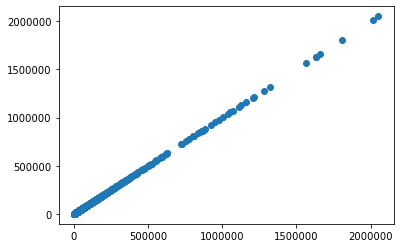

In [82]:
df_samp['duration_from_dates_2'] = (df_samp['End Date 3'] - df_samp['Start Date 2'])/np.timedelta64(1,'s')
plt.scatter(df_samp['Duration 2'].tolist(), df_samp['duration_from_dates_2'].tolist())

## Checking if python script has implemented correctly

In [83]:
cleaned_path = Path('tfl_project/data/cycle_journeys/JourneysDataCombined_CLEANSED.csv')

In [84]:
p = 0.02
random.seed(16)
df_cleansed = pd.read_csv(
        cleaned_path
        ,header=0
        ,sep=','
        ,skiprows=lambda i: i>0 and random.random() > p
        ,parse_dates=['Start Date', 'End Date']
        ,infer_datetime_format=True
        ,dayfirst=True
)

In [85]:
df_cleansed[df_cleansed['Start Date'] < '2012']

,Rental Id,Duration,Bike Id,End Date,EndStation Id,Start Date,StartStation Id
1258713,12533291.0,NaN,5871.0,NaT,NaN,1901-04-22,478.0


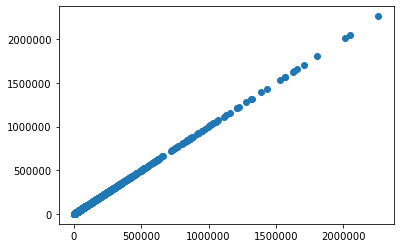

In [86]:
df_cleansed['duration_from_dates'] = (df_cleansed['End Date'] - df_cleansed['Start Date'])/np.timedelta64(1,'s')
plt.scatter(df_cleansed['Duration'].tolist(), df_cleansed['duration_from_dates'].tolist())

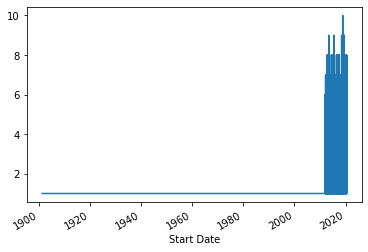

In [87]:
# Plot 'corrected' timeseries of journeys
df_cleansed.groupby('Start Date').count()['Rental Id'].plot()

Ultimately some issues persist with early start date, but I always specify a year range when using the data anyway

---
# Cleanse Stations
We will need to cleanse the station ids as certain files have corrupted schemas. 

But, this could turn-out to be quite a big part of the project! 

In [88]:
st_lkp = pd.read_csv(stations_path)

In [89]:
st_lkp

,Station ID,Station Name
0,1027,"Warwick Avenue Station, Maida Vale"
1,1102,"Leman Street, Aldgate"
2,1103,"Pimlico,0"
3,506,Bell Lane: Liverpool Street
4,251,Brushfield Street: Liverpool Street
...,...,...
2916,3427,"Hoxton,0"
2917,200175,"Wandsworth Rd, Isley Court, Wandsworth Road"
2918,3490,"Paddington,0"
2919,466,Whiston Road: Haggerston


## Fetch an authority lookup from the TfL API

In [90]:
def read_api_credentials(txt_file):
    """User is required to save a txt file with two lines: the first being their applicationID
    and the second being their application key"""
    global credentials
    credentials = {}
    with open(txt_file) as f:
        credentials['app_id'] = f.readline().rstrip()
        credentials['app_key'] = f.readline().rstrip()

In [93]:
creds = Path('tfl_project/tfl_api_logger/apiCredentials.txt')

In [94]:
read_api_credentials(creds)

In [95]:
import requests
import json

In [96]:
response = requests.get('https://api.tfl.gov.uk/bikepoint', params=credentials)

In [97]:
response.json()[0]

{'$type': 'Tfl.Api.Presentation.Entities.Place, Tfl.Api.Presentation.Entities',
 'id': 'BikePoints_1',
 'url': '/Place/BikePoints_1',
 'commonName': 'River Street , Clerkenwell',
 'placeType': 'BikePoint',
 'additionalProperties': [{'$type': 'Tfl.Api.Presentation.Entities.AdditionalProperties, Tfl.Api.Presentation.Entities',
   'category': 'Description',
   'key': 'TerminalName',
   'sourceSystemKey': 'BikePoints',
   'value': '001023',
   'modified': '2020-08-28T16:44:59.04Z'},
  {'$type': 'Tfl.Api.Presentation.Entities.AdditionalProperties, Tfl.Api.Presentation.Entities',
   'category': 'Description',
   'key': 'Installed',
   'sourceSystemKey': 'BikePoints',
   'value': 'true',
   'modified': '2020-08-28T16:44:59.04Z'},
  {'$type': 'Tfl.Api.Presentation.Entities.AdditionalProperties, Tfl.Api.Presentation.Entities',
   'category': 'Description',
   'key': 'Locked',
   'sourceSystemKey': 'BikePoints',
   'value': 'false',
   'modified': '2020-08-28T16:44:59.04Z'},
  {'$type': 'Tfl.Api

In [98]:
bp_ids = [int(d['id'][11:]) for d in response.json()]

In [99]:
t_names = []

for d in response.json():
    for prop in d['additionalProperties']:
        if prop['key'] == 'TerminalName':
            t_names.append(int(prop['value']))

In [100]:
commonNames = [d['commonName'] for d in response.json()]

In [101]:
bp_dict = dict(zip(bp_ids, commonNames))

In [102]:
tn_dict = dict(zip(t_names, commonNames))

## Merge our station_lookup with this authority data

In [103]:
for i, row in st_lkp.iterrows():
    try:
        st_id = int(row['Station ID'])
    except ValueError:
        st_id = np.nan
    if st_id in bp_dict:
        st_lkp.at[i, 'bikepoint_desc'] = bp_dict[st_id]
    else:
        st_lkp.at[i, 'bikepoint_desc'] = ''
    if st_id in tn_dict:
        st_lkp.at[i, 'terminalname_desc'] = tn_dict[st_id]
    else:
        st_lkp.at[i, 'terminalname_desc'] = ''

In [104]:
for i, row in st_lkp.iterrows():
    if (row['bikepoint_desc'] != '') & (row['terminalname_desc'] != ''):
        if ['bikepoint_desc'] == row['terminalname_desc']:
            result = 'Agreement (no ambiguity)'
        else:
            result = 'Disagreement (ambiguity)'
    elif (row['bikepoint_desc']== '') & (row['terminalname_desc'] == ''):
        result = 'No result (ambiguity)'
    else:
        result = 'One result (no ambiguity)'
    st_lkp.at[i, 'result'] = result

In [105]:
st_lkp['result'].value_counts()

One result (no ambiguity)    2799
No result (ambiguity)         122
Name: result, dtype: int64

In [106]:
still_no_result = st_lkp[st_lkp['result'] == 'No result (ambiguity)']

In [107]:
from itertools import compress

In [109]:
search = "Oval Way"

In [110]:
list(compress(
    commonNames
    ,[search in st for st in commonNames]
))

[]

In [111]:
list(compress(
    bp_ids
    ,[search in st for st in commonNames]
))

[]

In [112]:
list(compress(
    t_names
    ,[search in st for st in commonNames]
))

[]